In [25]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas_profiling as pp

from scipy import stats as sps

from io import BytesIO, StringIO

%matplotlib inline

## To Do
1. Get data for number of individuals tested daily
2. Determine "start" of mass testing
3. Perform Analysis on Provincial Levels
4. Use Plotly

palette1 = https://www.color-hex.com/color-palette/15945  
palette2 = https://www.color-hex.com/color-palette/1407

## Load Data

Data is from [DOH's Data Drop](https://drive.google.com/open?id=1-rUCIfDkx9jj4EFCkIqsjGwmc9Los_Pp).

The [trick](https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public) to loading the csv file to pandas is to get the file id and use request to load the raw csv into into pandas.

In [36]:
src = 'https://drive.google.com/open?id=1sj-UAy2kefyif5NEWojyIPMSb0Aou64J'
file_id = src.split('=')[1]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

# format date columns
for col in df.columns:
    if 'Date' in col:
        df[col] = pd.to_datetime(df[col])
df.head(10)

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateRecover,DateDied,RemovalType,DateRepRem,Admitted,RegionRes,ProvCityRes
0,C100119,30.0,30 to 34,Male,2020-04-12,NaT,NaT,NaN,NaT,Yes,NCR,City of ParaÃ±aque
1,C100264,57.0,55 to 59,Male,2020-03-29,NaT,NaT,NaN,NaT,Yes,NCR,City of Mandaluyong
2,C100648,33.0,30 to 34,Female,2020-04-16,NaT,NaT,NaN,NaT,Yes,NCR,Quezon City
3,C100660,42.0,40 to 44,Female,2020-04-02,NaT,NaT,NaN,NaT,Yes,NCR,City of Pasig
4,C100776,42.0,40 to 44,Male,2020-04-01,NaT,NaT,NaN,NaT,Yes,Laguna,Pila
5,C101015,79.0,75 to 79,Male,2020-04-03,NaT,NaT,NaN,NaT,NaN,Quezon,Unisan
6,C101097,33.0,30 to 34,Male,2020-03-27,NaT,NaT,NaN,NaT,Yes,NCR,Quezon City
7,C101232,30.0,30 to 34,Male,2020-03-21,2020-03-25,NaT,Recovered,2020-03-28,Yes,NCR,City of Mandaluyong
8,C101376,29.0,25 to 29,Male,2020-04-11,NaT,NaT,NaN,NaT,Yes,NaN,NaN
9,C101483,40.0,40 to 44,Female,2020-04-14,NaT,NaT,NaN,NaT,Yes,NCR,City of San Juan


In [27]:
# pp.ProfileReport(df)

## Latest Statistics

In [37]:
total_cases = len(df)
recovered = len(df.loc[df.RemovalType=='Recovered'])
died = len(df.loc[df.RemovalType=='Died'])
active_cases = total_cases - recovered - died
percent_active = active_cases / total_cases
percent_recovered = recovered / total_cases
percent_died = died / total_cases

print(f'Total Cases: {total_cases} \nActive Cases: {active_cases}\
({100*percent_active:.1f}% of total cases)\n\
Recovered: {recovered} ({100*percent_recovered:.1f}% of total cases)\n\
Died: {died} ({100*percent_died:.1f}% of total cases)')

Total Cases: 6259 
Active Cases: 5278(84.3% of total cases)
Recovered: 572 (9.1% of total cases)
Died: 409 (6.5% of total cases)


## Daily Trend of Total and Active Cases,  Recovered, and Died

### Total Cases Per Day

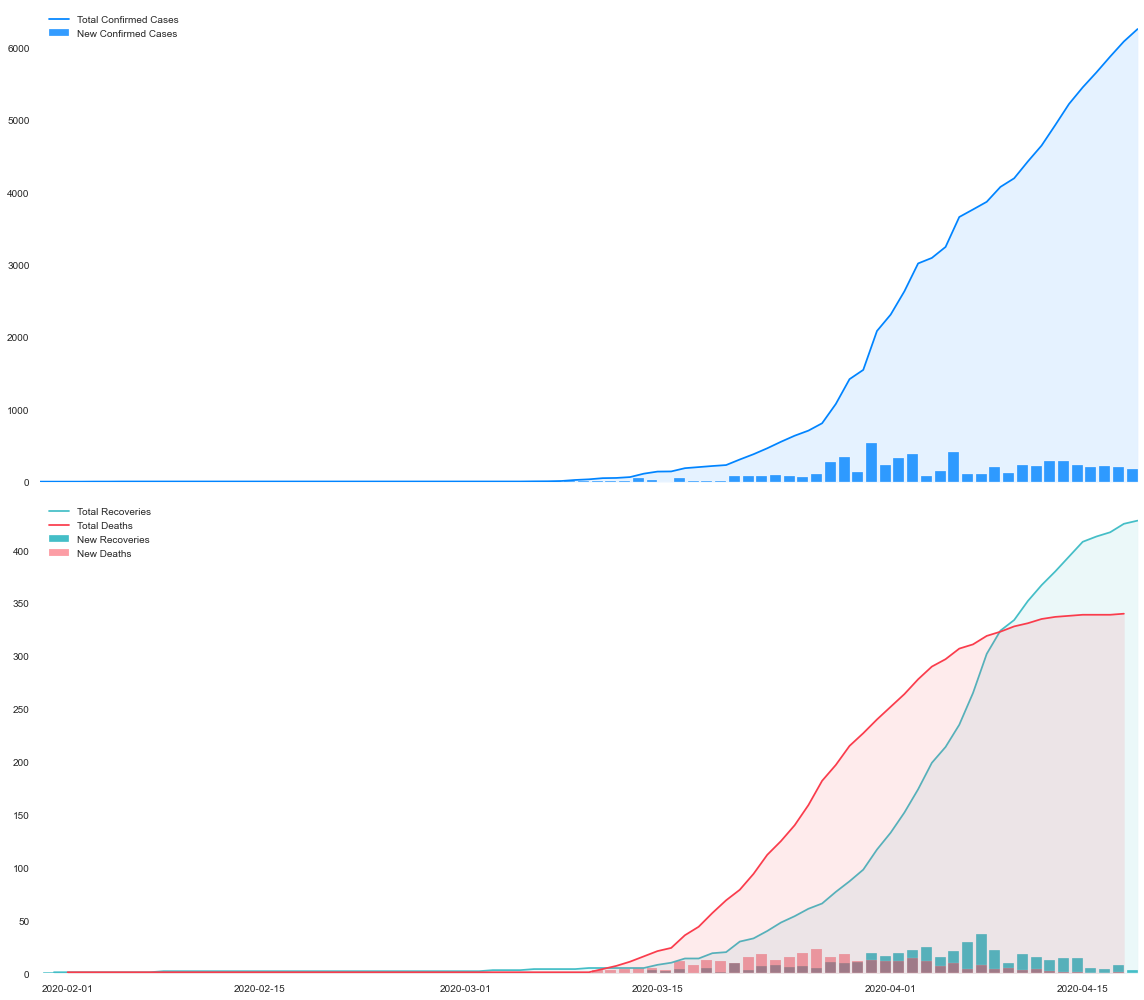

In [39]:
fig, ax = plt.subplots(2, figsize=(16, 14), sharex=True)

cases_per_day = (df.groupby('DateRepConf')['CaseCode']
                 .count().resample('1D').sum())

ax_ = ax[0]
x = cases_per_day.index.date
ax_.plot(x, cases_per_day.cumsum(), color='#0084ff',
        label='Total Confirmed Cases')
ax_.fill_between(x, y1=0, y2=cases_per_day.cumsum(), alpha=.1,
                color='#0084ff', label='')
ax_.bar(x, cases_per_day, color='#0084ff', alpha=.8,
       label='New Confirmed Cases', align='edge', width=-.8)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])
ax_.legend()

# recoveries
recoveries_per_day = (df.loc[df.RemovalType=='Recovered']
                      .groupby('DateRecover')['CaseCode']
                      .count().resample('1D').sum())

x = recoveries_per_day.index.date
ax_ = ax[1]
ax_.plot(x, recoveries_per_day.cumsum(),
         color='#44bec7', label='Total Recoveries', zorder=2)
ax_.fill_between(x, y1=0, y2=recoveries_per_day.cumsum(),
                 color='#44bec7', label='', alpha=.1, zorder=2)
ax_.bar(x, recoveries_per_day, color='#44bec7', alpha=1,
        label='New Recoveries', align='edge', width=-.8, zorder=0)

# deaths
deaths_per_day = (df.loc[df.RemovalType=='Died']
                  .groupby('DateDied')['CaseCode']
                  .count().resample('1D').sum())

x = deaths_per_day.index.date
ax_.plot(x, deaths_per_day.cumsum(),
         color='#fa3c4c', label='Total Deaths', zorder=3)
ax_.fill_between(x, y1=0, y2=deaths_per_day.cumsum(),
                 color='#fa3c4c', label='', alpha=.1, zorder=3)
ax_.bar(x, deaths_per_day, color='#fa3c4c', alpha=.5,
        label='New Deaths', align='edge', width=-.8, zorder=1)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])
ax_.legend()

fig.tight_layout();

Note: data on date of death and recovery is not accurate and explains why there are more recoveries in the plot above.

### Percent Active, Recovered, and Died

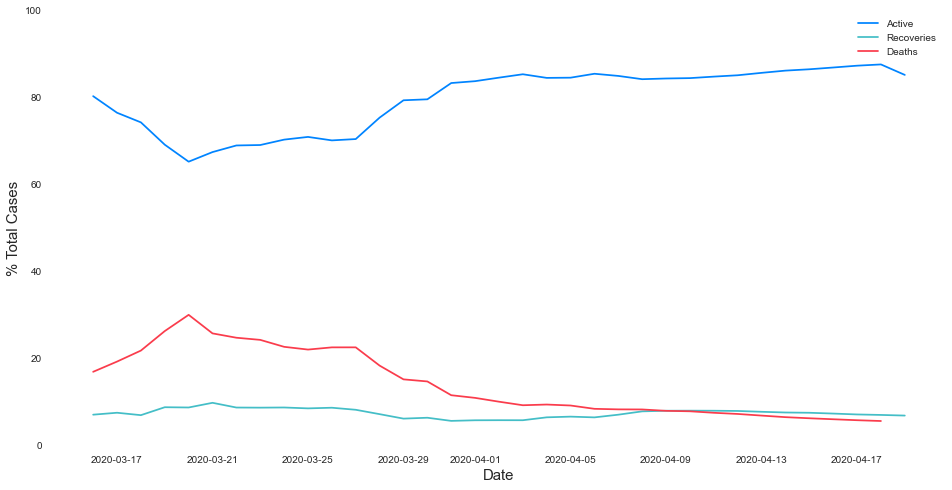

In [40]:
active_per_day = np.maximum(cases_per_day 
                            - recoveries_per_day 
                            - deaths_per_day, 0).fillna(0)
percent_active_per_day = (100 * active_per_day.cumsum() /
                          cases_per_day.cumsum())
percent_deaths_per_day = (100 * deaths_per_day.cumsum() /
                          cases_per_day.cumsum())
percent_recoveries_per_day = (100 * recoveries_per_day.cumsum() /
                              cases_per_day.cumsum())

fig, ax = plt.subplots(figsize=(16, 8))
x = cases_per_day.index[46:]
ax.plot(x, percent_active_per_day[x],
        color='#0084ff', label='Active')
ax.plot(x, percent_recoveries_per_day[x], color='#44bec7', label='Recoveries')
ax.plot(x, percent_deaths_per_day[x], color='#fa3c4c', label='Deaths')
ax.set_ylim(0, 100)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('% Total Cases', size=15)
ax.legend();

### Doubling Rate

### New Cases VS Total Cases

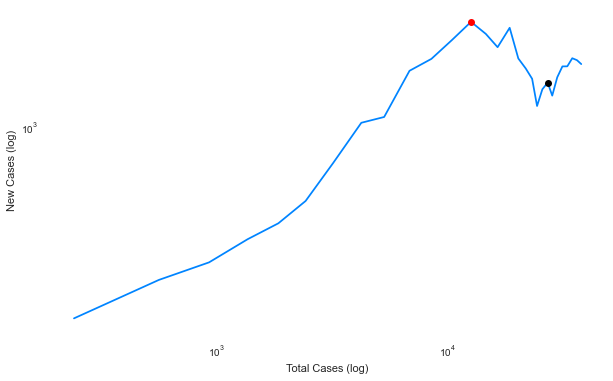

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum(),
          cases_per_day[x].rolling(window=7).sum(), color='#0084ff')
ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum().iloc[27],
          cases_per_day[x].rolling(window=7).sum().iloc[27],
          color='k', marker='o')
ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum().iloc[18],
          cases_per_day[x].rolling(window=7).sum().iloc[18],
          color='red', marker='o')
ax.set_xlabel('Total Cases (log)')
ax.set_ylabel('New Cases (log)');

### Time to Recovery/Death

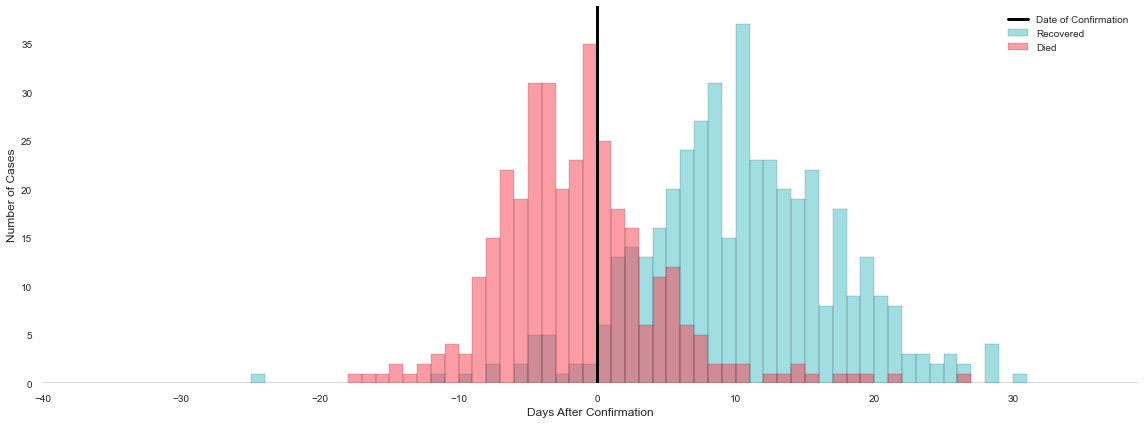

In [42]:
df_recovered = df.loc[(df.RemovalType=='Recovered')]
df_died = df.loc[(df.RemovalType=='Died')]

fig, ax = plt.subplots(figsize=(16, 6))
bins = np.arange(-40, 40)
((df_recovered.DateRecover - df_recovered.DateRepConf)
 .dt.days.hist(bins=bins, edgecolor='k', label='Recovered',
               facecolor='#44bec7', alpha=.5, ax=ax))

((df_died.DateDied - df_died.DateRepConf)
 .dt.days.hist(bins=bins, edgecolor='k', label='Died',
                    facecolor='#fa3c4c', alpha=.5, ax=ax))
ax.axvline(0, label='Date of Confirmation', linewidth=3, color='k')
ax.set_xlim(bins[0], bins[-1])
ax.grid(False)
ax.legend()
ax.set_ylabel('Number of Cases', size=12)
ax.set_xlabel('Days After Confirmation', size=12)
fig.tight_layout()

### Is It Getting Under Control?

#### Tests Performed Daily and Percent Positive

In [81]:
url = 'https://drive.google.com/open?id=1FeQwYfXRYhb6DTiRjVBztFn76paA3Cl8'
file_id = url.split('=')[1]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df_tests = pd.read_csv(csv_raw)

# format date
df_tests['Date'] = pd.to_datetime(df_tests['Date'])

# format count columns
cols = [col for col in df_tests.columns if 'INDIVIDUALS' in col]
for col in cols:
    df_tests[col] = df_tests[col].str.replace(',', '').astype(int)
        
df_tests.head()

,Name of Health Facility/Laboratory,Abbrev of Health Facility,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,% positive/ unique individuals,NEGATIVE INDIVIDUALS,% negative/ unique individuals,EQUIVOCAL,% equivocal /unique individuals,INVALID,% invalid /unique individuals,TOTAL TESTS CONDUCTED,%,REMAINING NUMBER OF TESTS,%.1,Date
0,Research Institute for Tropical Medicine (RITM),RITM,NaN,NaN,NaN,15197,2652,17%,11367,75%,32,0.2%,NaN,NaN,"20,826",NaN,"75,396",NaN,2020-04-02
1,Baguio General Hospital and Medical Center (BG...,BGHMC,NaN,NaN,NaN,473,21,4%,452,96%,0,0.0%,NaN,NaN,478,NaN,"4,519",NaN,2020-04-02
2,San Lazaro Hospital (SLH),SLH,NaN,NaN,NaN,115,31,27%,84,73%,0,0.0%,NaN,NaN,193,NaN,"4,846",NaN,2020-04-02
3,Vicente Sotto Memorial Medical Center (VSMMC),VSMMC,NaN,NaN,NaN,672,37,6%,634,94%,1,0.1%,NaN,NaN,672,NaN,"23,812",NaN,2020-04-02
4,UP National Institutes of Health (UP-NIH),UP-NIH,NaN,NaN,NaN,332,43,13%,279,84%,10,3.0%,NaN,NaN,335,NaN,"4,565",NaN,2020-04-02


In [85]:
df_test_counts = df_tests.groupby('Date')[cols].sum().resample('1D').sum()
df_test_counts.tail()

,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS
Date,,,
2020-04-14,39947,5782,34116
2020-04-15,42215,6188,35985
2020-04-16,45880,6498,39340
2020-04-17,49613,6894,42677
2020-04-18,52837,7166,45626


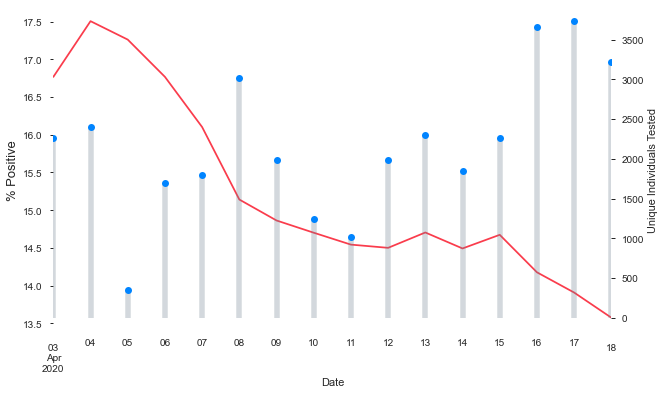

In [179]:
fig, ax = plt.subplots(figsize=(10, 6))

((100*(df_test_counts.iloc[:, 1] / 
       (df_test_counts.iloc[:, 1] + df_test_counts.iloc[:, 2])))
 .plot(ax=ax, color='#fa3c4c'))
ax.set_ylabel('% Positive', fontsize=13)
# ax.set_ylim(12, 18)

ax2 = ax.twinx()
daily_tests = df_test_counts.iloc[:, 0].diff().dropna()
daily_tests.plot(ax=ax2, marker='o', linestyle='', color='#0084ff')
ax2.vlines(x=daily_tests.index, ymin=0, color='#708090',
           ymax=daily_tests.values, alpha=.3,
           linewidth=5.5)
ax2.set_ylabel('Unique Individuals Tested');
# ax2.set_ylim(0, )

#### Rolling Bayesian Rt Estimate

Code is copied directly from [Kevin Systrom's Github Notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

In [43]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [44]:
cases = cases_per_day.cumsum()
original, smoothed = prepare_cases(cases)

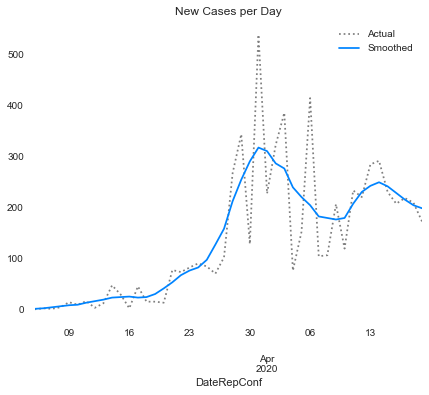

In [45]:
original.plot(title=f"New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 400/72))

ax = smoothed.plot(label='Smoothed', color='#0084ff',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [46]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.15)

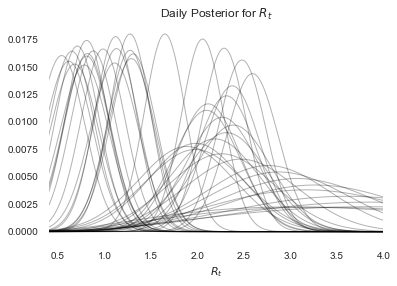

In [47]:
ax = posteriors.plot(title=f'Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

In [48]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

In [49]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
DateRepConf,,,
2020-04-15,1.13,0.74,1.53
2020-04-16,0.99,0.59,1.38
2020-04-17,0.88,0.49,1.29
2020-04-18,0.82,0.41,1.22
2020-04-19,0.81,0.42,1.25


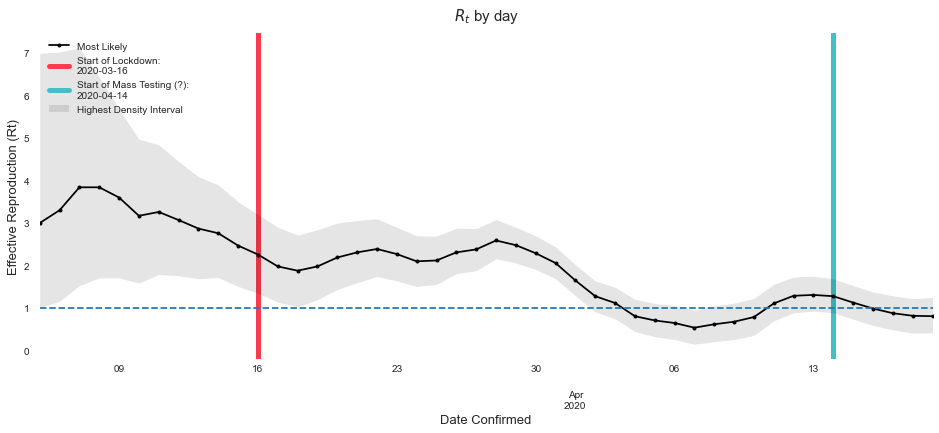

In [91]:
fig, ax = plt.subplots(figsize=(16, 6))
most_likely.plot(marker='o',
                 label='Most Likely',
                 c='k',
                 zorder=2,
                 markersize=4,
                 ax=ax)

ax.fill_between(hdis.index,
                hdis['Low_90'],
                hdis['High_90'],
                color='k',
                zorder=1,
                alpha=.1,
                lw=0,
                label='Highest Density Interval')

ax.axhline(1, linestyle='--')
ax.axvline(most_likely.index[11], linewidth=5,
           zorder=0, color='#fa3c4c',
           label=f'Start of Lockdown: \n{str(most_likely.index[11].date())}')

ax.axvline(most_likely.index[40], linewidth=5,
           zorder=0, color='#44bec7',
           label=f'Start of Mass Testing (?): \n{str(most_likely.index[40].date())}')

ax.set_xlabel('Date Confirmed', size=13)
ax.set_ylabel('Effective Reproduction (Rt)', size=13)
ax.set_title(f'$R_t$ by day', size=15, y=1.02)
ax.legend();